In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd

In [2]:
# Adapted from https://github.com/mwaskom/seaborn/issues/2280
def control_legend(ax, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, title=title, **kws)

In [3]:
# Load in data for single experiment
experiment = 4
output_path = f'output/FullFrame/Experiment {experiment}/'
df = pd.read_pickle(output_path + 'df.pkl')

# TODO: add mult factor for lower res image distances

df.head()

,i,j,"(i, j)",Root,Chitin Band,Level,Close2Root,Close2Chitin,Close2Both,Dist2Root,Dist2Chitin,Dist2Both,Stain,Both,RawStain
0,0,0,"(0, 0)",True,False,A,False,False,False,0.0,NaN,0.0,11.710828,False,255
1,0,1,"(0, 1)",True,False,A,False,False,False,0.0,NaN,0.0,11.710828,False,255
2,0,2,"(0, 2)",False,False,A,False,False,False,1.0,NaN,1.0,11.710828,False,255
3,0,3,"(0, 3)",False,False,A,False,False,False,2.0,NaN,2.0,11.710828,False,255
4,0,4,"(0, 4)",False,False,A,False,False,False,3.0,NaN,3.0,11.710828,False,255


In [4]:
## Functions ##
from matplotlib.offsetbox import AnchoredText

def pval(m1, m2):
    return round(scipy.stats.ttest_ind(m1, m2)[1], 2)

def add_pvalues(ax, df, x_col, y_col, loc):
    # ax: to draw on
    # df: to pull data from
    # x_col: to be split into unique values
    # y_col: to perform stats on
    # loc: matplotlib style legend location string

    # Form text block
    text = 'P-values:'
    classes = df[x_col].unique()
    for i, a in enumerate(classes):
        temp_a = df[df[x_col] == a][y_col]  # Pull a values
        for b in classes[i + 1:]:
            temp_b = df[df[x_col] == b][y_col]  # Pull b values

            if len(temp_a) > 0 and len(temp_b) > 0:
                res = pval(temp_a, temp_b)  # Calculate P-value
                if res <= 0.001:
                    res = '<0.001'
            else:
                res = 'NaN'

            # Add result to text
            text += '\n'
            text += '   {} vs. {}: {}'.format(a, b, res)

    # Add to plot
    anc = AnchoredText(text, loc=loc, frameon=False)
    ax.add_artist(anc)


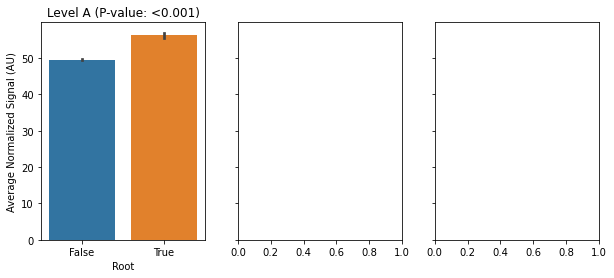

In [5]:
# Split by classification and level with a new subplot for each level
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
plt.subplots_adjust(wspace=0.2)
for level, ax in zip(df['Level'].unique(), axes.flatten()):
    temp = df[df['Level'] == level]
    sns.barplot(data=temp, x='Root', y='RawStain', ax=ax, order=[False, True])
    
    ax.set_ylabel(None)

    # Each of these only has 2 classes
    classes = [False, True]
    x = temp[temp['Root'] == classes[0]]['RawStain']
    y = temp[temp['Root'] == classes[1]]['RawStain']
    if len(x) > 0 and len(y) > 0:
        res = pval(x, y)
        if res <= 0.001:
            res = '<0.001'
    else:
        res = 'NaN'
    ax.set_title('Level {} (P-value: {})'.format(level, res))

axes[0].set_ylabel('Average Normalized Signal (AU)')
plt.savefig(output_path + 'Barplot_Levels_Classes_Subplots_Pvalues',
            dpi=400, bbox_inches='tight')
plt.show()

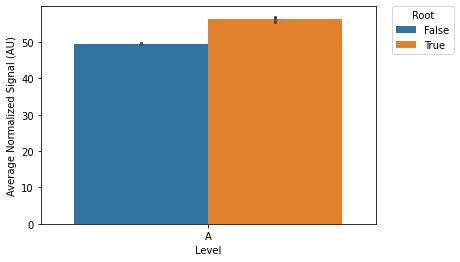

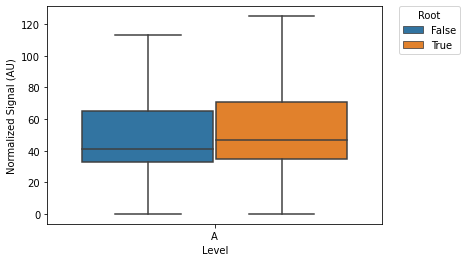

In [6]:
# Split by classification and level, all in one plot
ax = sns.barplot(data=df, x='Level', y='RawStain', hue='Root', hue_order=[False, True])
plt.ylabel('Average Normalized Signal (AU)')
control_legend(ax, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(output_path + 'Barplot_Levels_Classes',
            dpi=400, bbox_inches='tight')
plt.show()

ax = sns.boxplot(data=df, x='Level', y='RawStain', hue='Root', showfliers=False, hue_order=[False, True])
plt.ylabel('Normalized Signal (AU)')
control_legend(ax, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(output_path + 'Boxplot_Levels_Classes',
            dpi=400, bbox_inches='tight')
plt.show()

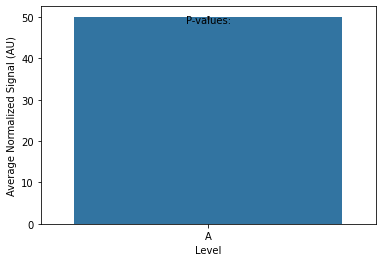

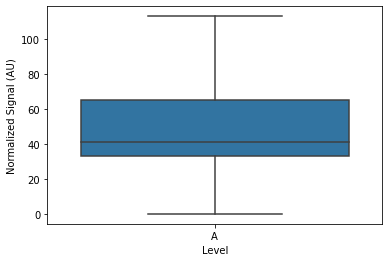

In [7]:
# Compare across levels
ax = sns.barplot(data=df, x='Level', y='RawStain')
plt.ylabel('Average Normalized Signal (AU)')
plt.savefig(output_path + 'Barplot_Levels',
            dpi=400, bbox_inches='tight')
add_pvalues(ax, df, 'Level', 'RawStain', 'upper center')
plt.savefig(output_path + 'Barplot_Levels_Pvalues',
            dpi=400, bbox_inches='tight')
plt.show()

ax = sns.boxplot(data=df, x='Level', y='RawStain', showfliers=False)
plt.ylabel('Normalized Signal (AU)')
plt.savefig(output_path + 'Boxplot_Levels',
            dpi=400, bbox_inches='tight')
plt.show()

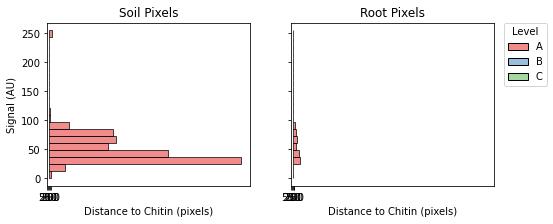

In [8]:

palette = ['#e41a1c', '#377eb8', '#4daf4a']
temp_palette = [palette[0], palette[2], palette[1]]

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True, sharex=True)
for ax, root in zip(axes.flatten(), [False, True]):
    
    temp = df.copy()
    temp.loc[temp['Level'] == 'A', 'Dist2Chitin'] *= -1
    temp = temp[temp['Root'] == root]

    if len(temp) > 0:
        sns.histplot(data=temp, x='Dist2Chitin', y='RawStain', hue='Level',
                    hue_order=('A', 'C', 'B'), bins=21, palette=temp_palette, ax=ax,
                    legend=~root, pthresh=0.05)
    ax.set_xlabel('Distance to Chitin (pixels)')
    
    ax.set_xticks([-500, -250, 0, 250, 500])
    ax.set_xticklabels([500, 250, 0, 250, 500])

    legend = ax.get_legend()
    if root:
        ax.set_title('Root Pixels')
        ax.set_ylabel(None)

        if len(temp) > 0:  # Avoid errors
            handles = legend.legendHandles
            handles = [handles[0], handles[2], handles[1]]
            legend.remove()
            ax.legend(handles=handles, labels=['A', 'B', 'C'], title='Level', loc='upper right')
            control_legend(ax, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    else:
        ax.set_title('Soil Pixels')
        ax.set_ylabel('Signal (AU)')
        legend.remove()

plt.savefig(output_path + f'Hist2D_Dist2Chitin', dpi=400, bbox_inches='tight')
plt.show()

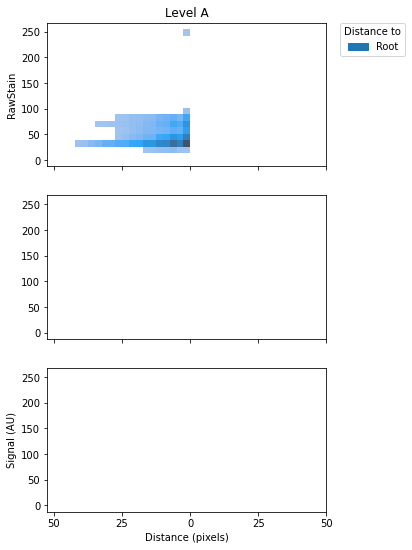

In [9]:
temp = df.copy()
temp = temp[['(i, j)', 'RawStain', 'Dist2Root', 'Dist2Chitin', 'Level']]
temp['Dist2Root'] *= -1
temp = temp.rename(columns={'Dist2Root': 'Root', 'Dist2Chitin': 'Chitin Band'})
temp = temp.melt(id_vars=('(i, j)', 'Level', 'RawStain'), value_vars=('Root', 'Chitin Band'), var_name='Distance to')
temp = temp[abs(temp['value']) < 50]

fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.2)
for level, ax in zip(df['Level'].unique(), axes.flatten()):
    temp_level = temp[temp['Level'] == level]

    # palette = ['#e41a1c', '#377eb8', '#4daf4a'] # TODO: choose 3 other colors
    ax = sns.histplot(data=temp_level, x='value', y='RawStain', hue='Distance to', bins=20, ax=ax, pthresh=0.05)
    ax.set_title(f'Level {level}')
    plt.ylabel('Signal (AU)')
    control_legend(ax, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks([-50, -25, 0, 25, 50], [50, 25, 0, 25, 50])
plt.xlabel('Distance (pixels)')

plt.savefig(output_path + 'Hist2D_Dist2Both_Levels', dpi=400, bbox_inches='tight')
plt.show()